a notebook to test recipe

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from classes.matrix_class import ProteinMatrix
from classes.cluster_class import AllClusters
from classes.degreelist_class import DegreeList

from func_e.FUNC_E import FUNC_E 
import func_e.vocabs.all as vocabs


from recipe_utils import initialize_matrix_clusters_degreelist
from recipe_utils import find_clusters_and_proteins_together
from recipe_utils import print_querylist_of_clusters_to_file
from recipe_utils import get_initialized_fe
from recipe_utils import print_protein_background_to_file


In [2]:
import matplotlib.pyplot as plt
import json


In [1]:
def create_term_mapping_list(go_terms_filepath: str, term_mapping_filepath: str = 'term_mapping.txt'):
    """
    the original file (go_terms_filepath) is in form GOTERM tab PROTEIN, while the term mapping file (term_mapping_filepath) is printed in form PROTEIN tab GOTERM. if a protein has multiple they appear on seperate lines
    """
    with open(term_mapping_filepath, 'w') as file:
        with open(go_terms_filepath, 'r') as go_annotation_file:
            for _ in range(1): # first line of file has column titles, and should be skipped
                next(go_annotation_file)
            for line in go_annotation_file:
                terms = line.split()
                file.write(f"{terms[1]}\t{terms[0]}\n")

In [5]:
dream3_cluster_dict_file = "../data/results/DREAM-3-cc/d3_5_100.json-cluster.json"
dict_of_clusters = {}
# # convert actual cluster file to a dictionary!!
with open(dream3_cluster_dict_file,"r") as cluster_dict_file:
    dict_of_clusters = json.load(cluster_dict_file)


In [6]:
matrix, clusters, degreelist = initialize_matrix_clusters_degreelist("../data/networks/DREAM_files/dream_3.txt", "../data/results/DREAM-3-cc/d3_5_100.json-cluster.json")

In [7]:
genomic_background_filepath = '../data/testing_data/protein_list.txt'
all_go_terms = vocabs.getTerms(['GO'])
term_mapping_filepath = 'term_mapping.txt'
create_term_mapping_list('../data/go-results/dream_3_go_results.tsv', term_mapping_filepath)

In [8]:
qualifying_clusters, qualifying_proteins = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio=0, cluster_constant=0, protein_ratio=1, protein_constant=0, use_sqrt=True)

In [10]:
print(qualifying_proteins.keys())

dict_keys([10, 11, 20, 25, 26, 27, 28, 32, 33, 38, 39, 41, 42, 47, 49, 61, 65, 74, 78, 79, 85, 87, 89, 91, 98, 106, 107, 110, 114, 117, 118, 119, 122, 123, 137, 138, 146, 149, 152, 156, 158, 160, 161, 170, 172, 175, 183, 185, 189, 193, 194, 198])


In [9]:
original_clusters_querylist = 'og_querylist.txt'
updated_clusters_querylist_all_proteins = 'new_querylist_all_proteins.txt'

# original:
print_querylist_of_clusters_to_file(clusters, qualifying_proteins.keys(),original_clusters_querylist)

# clusters with all proteins added:
print_querylist_of_clusters_to_file(clusters, qualifying_proteins.keys(), updated_clusters_querylist_all_proteins, qualifying_proteins)

In [11]:
original_fe = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

original_fe.importFiles({'query': original_clusters_querylist })
original_fe.run(cluster=False)


In [12]:
updated_fe_all_proteins = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_all_proteins.importFiles({'query': updated_clusters_querylist_all_proteins })
updated_fe_all_proteins.run(cluster=False)

In [13]:
# add only 1 protein
one_qualifying_protein = dict()
for key in qualifying_proteins:
    one_qualifying_protein[key] = [qualifying_proteins[key][0]]


updated_clusters_querylist_one_protein = 'new_querylist_one_protein.txt'
print_querylist_of_clusters_to_file(clusters, one_qualifying_protein.keys(), updated_clusters_querylist_one_protein, one_qualifying_protein)

# run functional enrichment for 1 protein added
updated_fe_one_protein = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)
updated_fe_one_protein.importFiles({'query': updated_clusters_querylist_one_protein })
updated_fe_one_protein.run(cluster=False)

In [17]:
# add only (up to) 3 proteins
three_qualifying_proteins = dict()
for key in qualifying_proteins:
    three_qualifying_proteins[key] = qualifying_proteins[key][0:3]

updated_clusters_querylist_three_proteins = 'new_querylist_three_proteins.txt'
print_querylist_of_clusters_to_file(clusters, three_qualifying_proteins.keys(), updated_clusters_querylist_three_proteins, three_qualifying_proteins)

# run functional enrichment for 3 proteins added
updated_fe_three_proteins = get_initialized_fe(genomic_background_filepath, 

term_mapping_filepath, termlist = all_go_terms)
updated_fe_three_proteins.importFiles({'query': updated_clusters_querylist_three_proteins })

updated_fe_three_proteins.run(cluster=False)

In [22]:
print(f"number of clusters that were updated with 1 protein, 3 proteins, all proteins: {len(qualifying_proteins.keys())}\n")

# clusters that are functionall enriched
print(f"number of functionally enriched clusters (modules) out of {len(qualifying_proteins.keys())} original clusters: {original_fe.enrichment['Module'].nunique()}")

print(f"number of functionally enriched clusters after addition of 1 protein: {updated_fe_one_protein.enrichment['Module'].nunique()}")

print(f"number of functionally enriched clusters after addition of 3 proteins: {updated_fe_three_proteins.enrichment['Module'].nunique()}")
# TODO for above and below figure out avg number of proteins added
print(f"number of functionally enriched clusters after addition of all proteins: {updated_fe_all_proteins.enrichment['Module'].nunique()}")



print(f"")



# significant P-values!!!
print(f"number of significant pvals in original clusters before updating: {original_fe.enrichment['Fishers_pvalue'].count()}")

print(f"number of significant pvals in clusters with 1 protein added: {updated_fe_one_protein.enrichment['Fishers_pvalue'].count()}")

print(f"number of significant pvals in clusters with up to 3 proteins added: {updated_fe_three_proteins.enrichment['Fishers_pvalue'].count()}")
# TODO for above and below figure out avg number of proteins added
print(f"number of significant pvals in clusters with all proteins added: {updated_fe_all_proteins.enrichment['Fishers_pvalue'].count()}")



number of clusters that were updated with 1 protein, 3 proteins, all proteins: 52

number of functionally enriched clusters (modules) out of 52 original clusters: 40
number of functionally enriched clusters after addition of 1 protein: 46
number of functionally enriched clusters after addition of 3 proteins: 48
number of functionally enriched clusters after addition of all proteins: 48

number of significant pvals in original clusters before updating: 105
number of significant pvals in clusters with 1 protein added: 131
number of significant pvals in clusters with up to 3 proteins added: 181
number of significant pvals in clusters with all proteins added: 179


In [ ]:
# TODO find the avg number of proteins added for 3 and all proteins

In [23]:
# TODO find which GO terms are new and which are old

/var/folders/hk/q40rrztn3glcl0jvwjcpzyth0000gn/T/ipykernel_8900/4237206988.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values, ha='center', fontsize=12)


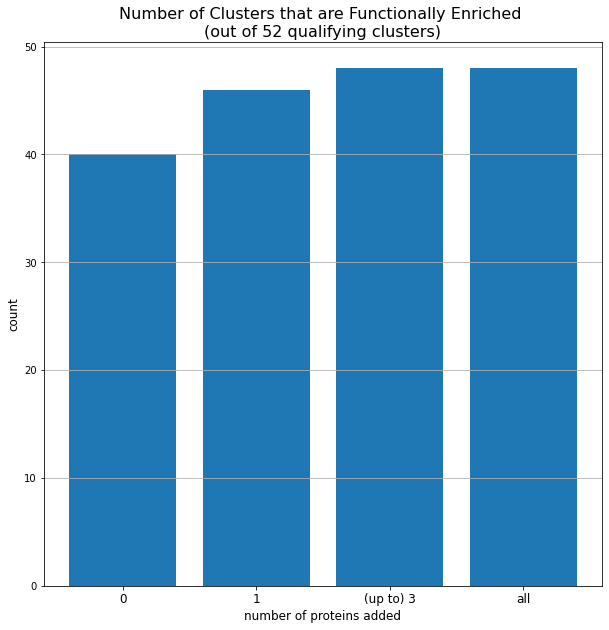

In [42]:

fig, ax = plt.subplots()

x_values = ["0", "1", "(up to) 3", "all"]
counts = [original_fe.enrichment['Module'].nunique(), updated_fe_one_protein.enrichment['Module'].nunique(), updated_fe_three_proteins.enrichment['Module'].nunique(), updated_fe_all_proteins.enrichment['Module'].nunique()]

ax.bar(x_values, counts)

ax.set_xticklabels(x_values, ha='center', fontsize=12)

ax.set_title(f"Number of Clusters that are Functionally Enriched \n(out of {len(qualifying_proteins.keys())} qualifying clusters)", fontsize=16)
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('number of proteins added', fontsize=12)

ax.grid(axis='y')

fig.set_size_inches(10,10)
plt.show()


/var/folders/hk/q40rrztn3glcl0jvwjcpzyth0000gn/T/ipykernel_8900/3614475595.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values, ha='center', fontsize=12)


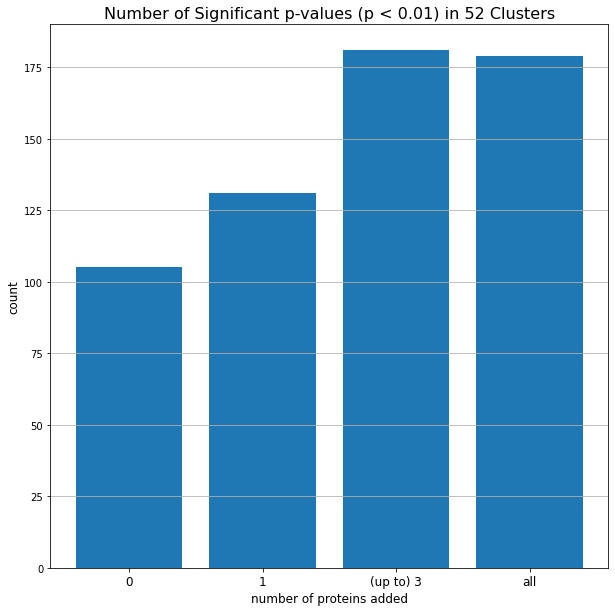

In [44]:
fig, ax = plt.subplots()

x_values = ["0", "1", "(up to) 3", "all"]
counts = [original_fe.enrichment['Fishers_pvalue'].count(), updated_fe_one_protein.enrichment['Fishers_pvalue'].count(), updated_fe_three_proteins.enrichment['Fishers_pvalue'].count(), updated_fe_all_proteins.enrichment['Fishers_pvalue'].count()]

ax.bar(x_values, counts)

ax.set_xticklabels(x_values, ha='center', fontsize=12)

ax.set_title(f"Number of Significant p-values (p < 0.01) in {len(qualifying_proteins.keys())} Clusters", fontsize=16)

# TODO: do i want to say number of significant p-values, or do i want to say number of Go-Terms / labels etc

ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('number of proteins added', fontsize=12)

ax.grid(axis='y')

fig.set_size_inches(10,10)
plt.show()

